## Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

The first part of this notebook walks through a typical harmonization process on data retrieved from Cape Cod, MA. The second part of the notebook takes a deeper dive into exactly what is done to each water quality characteristic result and some ways to leverage additional functions in the package for special use cases.

### Simple workflow

#### Import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

  Cloning https://github.com/USEPA/harmonize-wq.git to c:\users\jbousqui\appdata\local\temp\pip-req-build-9remk9f4
  Resolved https://github.com/USEPA/harmonize-wq.git to commit a18a70d00540d7e8a41fb7b3c138c274ded05c35
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/USEPA/harmonize-wq.git 'C:\Users\jbousqui\AppData\Local\Temp\pip-req-build-9remk9f4'


#### Create dataretrieval query using a polygon for Area Of Interest

A url to a geojson is used to define the area to retrieve results, but this can come from a variety of sources, including a local shapefile.

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle

In [3]:
# Read geometry for Area of Interest from geojson file url
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
#aoi_url = r'<your filepath>\NewEngland.shp'  # Local shapefile alternative

<Axes: >

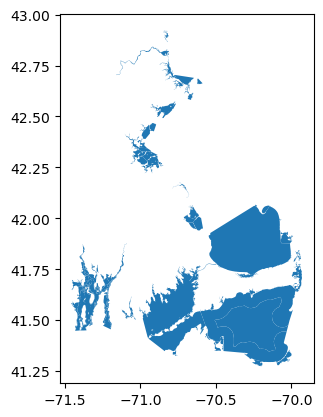

In [4]:
# Read aoi geojson to GeoDataFrame and reproject
aoi_gdf = wrangle.as_gdf(aoi_url)  
aoi_gdf = aoi_gdf.to_crs(epsg=4326)

# Map aoi (requires descartes/mapclassify)
aoi_gdf.plot() 

The Area Of Interest is made up of many small polygons. The query will be built from the total extent of these polygons, but alternatively could be restricted to the bounding box for just one such polygon.

In [5]:
bBox = wrangle.get_bounding_box(aoi_gdf)  # Bounding box string for total extent
#bBox = wrangle.get_bounding_box(aoi_gdf, idx=0)  # Bounding box string for specific polygon by index

In [6]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

#### Retrieve data

Stations and results meeting the query criteria are retrieved seperately. site_md and md_narrow are not used here but contain metadata to document and help reproduce the query/results in the future.

In [7]:
import dataretrieval.wqp as wqp

In [8]:
# Query for stations
stations, site_md = wqp.what_sites(**query)

In [9]:
# Query for results
# Note: large quieries like this can take up a lot of RAM and may give a DtypeWarning,
# set low_memory=False or provide dataTypes for columns to use less memory. 
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [10]:
# Look at initial results (input)
df = res_narrow
df

OrganizationIdentifier  \
0                        CRWA   
1                     MASSDEP   
2                        IRWA   
3                        CRWA   
4                     MASSDEP   
...                       ...   
334654                USGS-MA   
334655                USGS-MA   
334656                USGS-MA   
334657                USGS-MA   
334658                USGS-MA   

                                   OrganizationFormalName  \
0       Charles River Watershed Association (Massachus...   
1       Massachusetts Department of Environmental Prot...   
2         Ipswich River Watershed Association (Volunteer)   
3       Charles River Watershed Association (Massachus...   
4       Massachusetts Department of Environmental Prot...   
...                                                   ...   
334654            USGS Massachusetts Water Science Center   
334655            USGS Massachusetts Water Science Center   
334656            USGS Massachusetts Water Science Center   
334657            USGS Massachusetts Water Science Center   
334658            USGS Massachusetts Water Science Center   

               ActivityIdentifier ActivityStartDate ActivityStartTime/Time  \
0       CRWA-CYN20130809ROBTemp01        2013-08-09               11:14:33   
1                 MASSDEP-LB-5142        2013-07-30               14:20:00   
2       IRWA-HB:20130630120000:FM        2013-06-30               12:00:00   
3        CRWA-VMM20131217609SEC02        2013-12-17               07:40:00   
4                 MASSDEP-SM-4452        2013-09-25               09:05:00   
...                           ...               ...                    ...   
334654         nwisma.01.02301798        2023-07-05               10:30:00   
334655         nwisma.01.02301798        2023-07-05               10:30:00   
334656         nwisma.01.02301798        2023-07-05               10:30:00   
334657         nwisma.01.02301798        2023-07-05               10:30:00   
334658         nwisma.01.02301798        2023-07-05               10:30:00   

       ActivityStartTime/TimeZoneCode MonitoringLocationIdentifier  \
0                                 EST                     CRWA-ROB   
1                                 EDT                MASSDEP-W2173   
2                                 EDT                      IRWA-HB   
3                                 EST                    CRWA-609S   
4                                 EDT                MASSDEP-W0696   
...                               ...                          ...   
334654                            EDT                USGS-01100000   
334655                            EDT                USGS-01100000   
334656                            EDT                USGS-01100000   
334657                            EDT                USGS-01100000   
334658                            EDT                USGS-01100000   

        ResultIdentifier  DataLoggerLine ResultDetectionConditionText  ...  \
0       STORET-591631481  130809111433.0                          NaN  ...   
1       STORET-762955917             NaN                          NaN  ...   
2       STORET-853064665             NaN                          NaN  ...   
3       STORET-872379847             NaN                          NaN  ...   
4       STORET-762964497             NaN                          NaN  ...   
...                  ...             ...                          ...  ...   
334654    NWIS-125697600             NaN                          NaN  ...   
334655    NWIS-125697610             NaN                          NaN  ...   
334656    NWIS-125697637             NaN                          NaN  ...   
334657    NWIS-125697639             NaN                          NaN  ...   
334658    NWIS-125697643             NaN                          NaN  ...   

       AnalysisEndTime/TimeZoneCode ResultLaboratoryCommentCode  \
0                               NaN                         NaN   
1                           

#### Harmonize data using defaults

In [11]:
from harmonize_wq import harmonize
from harmonize_wq import location
from harmonize_wq import visualize

In [12]:
# Harmonize it and look at how it changed (output)
# Note: although we ignore unit dimensionality errors, it will warn when they are encountered and there are a lot of them
# Note: depedning on the version of Pint there may be a UnitStrippedWarning when working with None type units
df_harmonized = harmonize.harmonize_all(df, errors='ignore')
df_harmonized

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\s

OrganizationIdentifier  \
0                        CRWA   
1                     MASSDEP   
2                        IRWA   
3                        CRWA   
4                     MASSDEP   
...                       ...   
334654                USGS-MA   
334655                USGS-MA   
334656                USGS-MA   
334657                USGS-MA   
334658                USGS-MA   

                                   OrganizationFormalName  \
0       Charles River Watershed Association (Massachus...   
1       Massachusetts Department of Environmental Prot...   
2         Ipswich River Watershed Association (Volunteer)   
3       Charles River Watershed Association (Massachus...   
4       Massachusetts Department of Environmental Prot...   
...                                                   ...   
334654            USGS Massachusetts Water Science Center   
334655            USGS Massachusetts Water Science Center   
334656            USGS Massachusetts Water Science Center   
334657            USGS Massachusetts Water Science Center   
334658            USGS Massachusetts Water Science Center   

               ActivityIdentifier ActivityStartDate ActivityStartTime/Time  \
0       CRWA-CYN20130809ROBTemp01        2013-08-09               11:14:33   
1                 MASSDEP-LB-5142        2013-07-30               14:20:00   
2       IRWA-HB:20130630120000:FM        2013-06-30               12:00:00   
3        CRWA-VMM20131217609SEC02        2013-12-17               07:40:00   
4                 MASSDEP-SM-4452        2013-09-25               09:05:00   
...                           ...               ...                    ...   
334654         nwisma.01.02301798        2023-07-05               10:30:00   
334655         nwisma.01.02301798        2023-07-05               10:30:00   
334656         nwisma.01.02301798        2023-07-05               10:30:00   
334657         nwisma.01.02301798        2023-07-05               10:30:00   
334658         nwisma.01.02301798        2023-07-05               10:30:00   

       ActivityStartTime/TimeZoneCode MonitoringLocationIdentifier  \
0                                 EST                     CRWA-ROB   
1                                 EDT                MASSDEP-W2173   
2                                 EDT                      IRWA-HB   
3                                 EST                    CRWA-609S   
4                                 EDT                MASSDEP-W0696   
...                               ...                          ...   
334654                            EDT                USGS-01100000   
334655                            EDT                USGS-01100000   
334656                            EDT                USGS-01100000   
334657                            EDT                USGS-01100000   
334658                            EDT                USGS-01100000   

        ResultIdentifier  DataLoggerLine ResultDetectionConditionText  ...  \
0       STORET-591631481  130809111433.0                          NaN  ...   
1       STORET-762955917             NaN                          NaN  ...   
2       STORET-853064665             NaN                          NaN  ...   
3       STORET-872379847             NaN                          NaN  ...   
4       STORET-762964497             NaN                          NaN  ...   
...                  ...             ...                          ...  ...   
334654    NWIS-125697600             NaN                          NaN  ...   
334655    NWIS-125697610             NaN                          NaN  ...   
334656    NWIS-125697637             NaN                          NaN  ...   
334657    NWIS-125697639             NaN                          NaN  ...   
334658    NWIS-125697643             NaN                          NaN  ...   

                 Temperature Nitrogen Conductivity Sediment Fecal_Coliform  \
0       23.01 degree_Celsius      NaN          NaN      NaN            NaN   
1     

In [13]:
# Harmonize and clip sample locations
gdf_harmonized = location.harmonize_locations(stations)  # Harmonize
stations_clipped = wrangle.clip_stations(gdf_harmonized, aoi_gdf)  # Clip to area of interest

<Axes: >

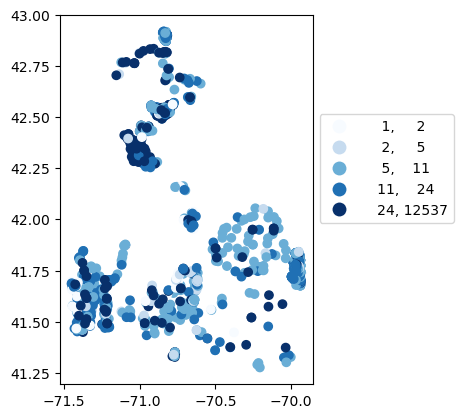

In [14]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df_harmonized, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<Axes: >

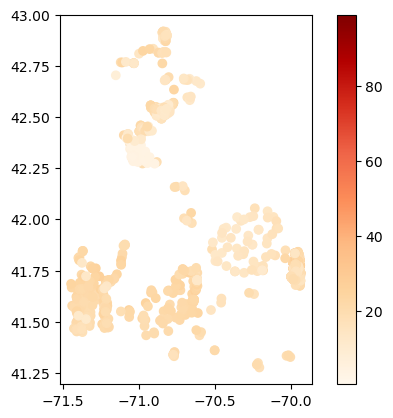

In [15]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_harmonized, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

#### Clean additional columns of data

In [16]:
from harmonize_wq import clean

In [17]:
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 104530 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


#### Reduce data to the columns that are most commonly needed

There are many columns in the dataframe that are characteristic specific, that is they have different values for the same sample depending on the characteristic. To ensure one result for each sample after the transformation of the data these columns must either be split, generating a new column for each characteristic with values, or moved out from the table if not being used.

In [18]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df_expanded = wrangle.split_col(df_cleaned)
df_expanded

OrganizationIdentifier  \
0                        CRWA   
1                     MASSDEP   
2                        IRWA   
4                     MASSDEP   
5                       MYRWA   
...                       ...   
334654                USGS-MA   
334655                USGS-MA   
334656                USGS-MA   
334657                USGS-MA   
334658                USGS-MA   

                                   OrganizationFormalName  \
0       Charles River Watershed Association (Massachus...   
1       Massachusetts Department of Environmental Prot...   
2         Ipswich River Watershed Association (Volunteer)   
4       Massachusetts Department of Environmental Prot...   
5       Mystic River Watershed Association (Massachuse...   
...                                                   ...   
334654            USGS Massachusetts Water Science Center   
334655            USGS Massachusetts Water Science Center   
334656            USGS Massachusetts Water Science Center   
334657            USGS Massachusetts Water Science Center   
334658            USGS Massachusetts Water Science Center   

                   ActivityIdentifier ActivityStartDate  \
0           CRWA-CYN20130809ROBTemp01        2013-08-09   
1                     MASSDEP-LB-5142        2013-07-30   
2           IRWA-HB:20130630120000:FM        2013-06-30   
4                     MASSDEP-SM-4452        2013-09-25   
5       MYRWA-MEB001:201304170651:L:S        2013-04-17   
...                               ...               ...   
334654             nwisma.01.02301798        2023-07-05   
334655             nwisma.01.02301798        2023-07-05   
334656             nwisma.01.02301798        2023-07-05   
334657             nwisma.01.02301798        2023-07-05   
334658             nwisma.01.02301798        2023-07-05   

       ActivityStartTime/Time ActivityStartTime/TimeZoneCode  \
0                    11:14:33                          -0500   
1                    14:20:00                          -0400   
2                    12:00:00                          -0400   
4                    09:05:00                          -0400   
5                    05:51:00                          -0500   
...                       ...                            ...   
334654               10:30:00                          -0400   
334655               10:30:00                          -0400   
334656               10:30:00                          -0400   
334657               10:30:00                          -0400   
334658               10:30:00                          -0400   

       MonitoringLocationIdentifier  ResultIdentifier  DataLoggerLine  \
0                          CRWA-ROB  STORET-591631481  130809111433.0   
1                     MASSDEP-W2173  STORET-762955917             NaN   
2                           IRWA-HB  STORET-853064665             NaN   
4                     MASSDEP-W0696  STORET-762964497             NaN   
5                      MYRWA-MEB001  STORET-495269151             NaN   
...                             ...               ...             ...   
334654                USGS-01100000    NWIS-125697600             NaN   
334655                USGS-01100000    NWIS-125697610             NaN   
334656                USGS-01100000    NWIS-125697637             NaN   
334657                USGS-01100000    NWIS-125697639             NaN   
334658                USGS-01100000    NWIS-125697643             NaN   

       ResultDetectionConditionText  ... QA_Temperature QA_Nitrogen  \
0                               NaN  ...            NaN         NaN   
1                               NaN  ...            NaN         NaN   
2                               NaN  ...            NaN         NaN   
4                               NaN  ...            NaN         NaN   
5                               NaN  ...            NaN         NaN   
...                             ...  ...            ...         ...   
334654                   

In [19]:
# Split table into main with columns of interest and characteristic specific columns/metadata
#116 columns into 47 and 69
main_df, chars_df = wrangle.split_table(df_expanded)

In [20]:
# Drop empty columns (QA columns without flags)
main_df_small = main_df.dropna(axis=1, how='all')

#### Transform data from long to wide format

In [21]:
transformed_df = wrangle.collapse_results(main_df_small)

Results are collapsed by retaining the first result that isn't NAN. There can be several reasons for multiple results for the same parameter/characteristic sampled at the same station, time and by the same organization. The collapse_results function assumes the user has already reviewed the quality of all results and narrowed down instances of multiple results to only the desired/best/highest quality result before running this function.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different characteristics

#### Download location data using dataretrieval

Everything is imported again in case this section is the starting point

In [22]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize

In [23]:
# Stations
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
bBox = wrangle.get_bounding_box(aoi_gdf)

In [24]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [25]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [26]:
# Rows and columns for results
stations.shape

(15517, 37)

In [27]:
# First 5 rows
stations.head()

OrganizationIdentifier             OrganizationFormalName  \
0                USGS-FL  USGS Florida Water Science Center   
1                USGS-FL  USGS Florida Water Science Center   
2                USGS-FL  USGS Florida Water Science Center   
3                USGS-FL  USGS Florida Water Science Center   
4                USGS-FL  USGS Florida Water Science Center   

  MonitoringLocationIdentifier  \
0                USGS-02300009   
1                USGS-02300018   
2                USGS-02300021   
3                USGS-02300062   
4                USGS-02300064   

                           MonitoringLocationName MonitoringLocationTypeName  \
0  MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL                    Estuary   
1                    GAMBLE CREEK NEAR PARRISH FL                     Stream   
2                  MANATEE RIVER AT FORT HAMER FL                    Estuary   
3                    GLEN CREEK NEAR BRADENTON FL                     Stream   
4                    BRADEN RIVER AT BRADENTON FL                     Stream   

  MonitoringLocationDescriptionText  HUCEightDigitCode  \
0                               NaN          3100202.0   
1                               NaN          3100202.0   
2                               NaN          3100202.0   
3                               NaN          3100202.0   
4                               NaN          3100202.0   

   DrainageAreaMeasure/MeasureValue DrainageAreaMeasure/MeasureUnitCode  \
0                             139.0                               sq mi   
1                              50.6                               sq mi   
2                             216.0                               sq mi   
3                               2.5                               sq mi   
4                              83.0                               sq mi   

   ContributingDrainageAreaMeasure/MeasureValue  ... AquiferName  \
0                                           NaN  ...         NaN   
1                                           NaN  ...         NaN   
2                                           NaN  ...         NaN   
3                                           NaN  ...         NaN   
4                                           NaN  ...         NaN   

   LocalAqfrName  FormationTypeText  AquiferTypeName ConstructionDateText  \
0            NaN                NaN              NaN                  NaN   
1            NaN                NaN              NaN                  NaN   
2            NaN                NaN              NaN                  NaN   
3            NaN                NaN              NaN                  NaN   
4            NaN                NaN              NaN                  NaN   

  WellDepthMeasure/MeasureValue WellDepthMeasure/MeasureUnitCode  \
0                           NaN                              NaN   
1                           NaN                              NaN   
2                           NaN                              NaN   
3                           NaN                              NaN   
4                           NaN                              NaN   

  WellHoleDepthMeasure/MeasureValue  WellHoleDepthMeasure/MeasureUnitCode  \
0                               NaN                                   NaN   
1                               NaN                                   NaN   
2                               NaN                                   NaN   
3                               NaN                                   NaN   
4                               NaN                                   NaN   

  ProviderName  
0         NWIS  
1         NWIS  
2         NWIS  
3         NWIS  
4         NWIS  

[5 rows x 37 columns]

In [28]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [29]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [30]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

Signature:
location.harmonize_locations(
    df_in,
    out_EPSG=4326,
    intermediate_columns=False,
    **kwargs,
)
Docstring:
Takes a DataFrame with lat/lon in multiple Coordinate Reference Systems,
transforms them to outCRS and converts to GeoDataFrame

Parameters
----------
df_in : pandas.DataFrame
    DataFrame with the required columns to be converted to GeoDataFrame.
out_EPSG : Integer, optional
    EPSG factory code for desired output Coordinate Reference System datum.
    The default is 4326, for the WGS84 Datum used by WQP queries.
intermediate_columns : Boolean, optional
    Return intermediate columns. Default 'False' does not return these.
Keyword Arguments:
crs_col : string, optional
    Name of column in DataFrame with the Coordinate Reference System datum.
    The default is 'HorizontalCoordinateReferenceSystemDatumName'.
lat_col : string, optional
    Name of column in DataFrame with the latitude coordinate.
    The default is 'LatitudeMeasure'.
lon_col : string, opt

In [31]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(15517, 42)

In [32]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [33]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [34]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

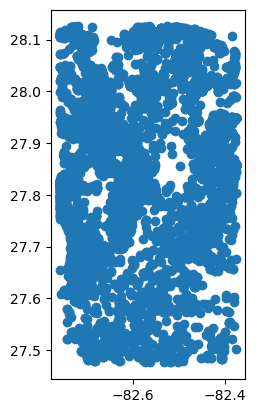

In [35]:
# Map it
stations_gdf.plot()

In [36]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

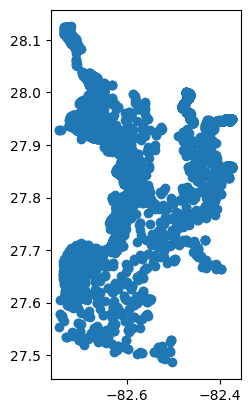

In [37]:
# Map it
stations_clipped.plot()

In [38]:
# How many stations now?
len(stations_clipped)

10224

In [39]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(, path, )'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [40]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,33,36,38,56,57,58,60,61,62,63,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [41]:
df = res_narrow
df

OrganizationIdentifier  \
0                 21FLHILL_WQX   
1                 21FLSEAS_WQX   
2                 21FLHILL_WQX   
3                 21FLHILL_WQX   
4                 21FLHILL_WQX   
...                        ...   
1420869                USGS-FL   
1420870                USGS-FL   
1420871                USGS-FL   
1420872                USGS-FL   
1420873                USGS-FL   

                                    OrganizationFormalName  \
0        Environmental Protection Commission of Hillsbo...   
1           Florida Department of Environmental Protection   
2        Environmental Protection Commission of Hillsbo...   
3        Environmental Protection Commission of Hillsbo...   
4        Environmental Protection Commission of Hillsbo...   
...                                                    ...   
1420869                  USGS Florida Water Science Center   
1420870                  USGS Florida Water Science Center   
1420871                  USGS Florida Water Science Center   
1420872                  USGS Florida Water Science Center   
1420873                  USGS Florida Water Science Center   

                ActivityIdentifier ActivityStartDate ActivityStartTime/Time  \
0         21FLHILL_WQX-130612585-W        2013-06-12               11:01:00   
1        21FLSEAS_WQX-481901119134        2013-11-19               14:01:00   
2         21FLHILL_WQX-130702047-M        2013-07-02               11:01:00   
3           21FLHILL_WQX-130716021        2013-07-16               11:01:00   
4         21FLHILL_WQX-131216112-M        2013-12-16               12:01:00   
...                            ...               ...                    ...   
1420869         nwisfl.01.95500762        1955-04-08                    NaN   
1420870         nwisfl.01.95500762        1955-04-08                    NaN   
1420871         nwisfl.01.95800924        1957-10-21               14:05:00   
1420872         nwisfl.01.95500782        1955-04-08                    NaN   
1420873         nwisfl.01.95500782        1955-04-08                    NaN   

        ActivityStartTime/TimeZoneCode MonitoringLocationIdentifier  \
0                                  EST             21FLHILL_WQX-585   
1                                  EST       21FLSEAS_WQX-48SEAS190   
2                                  EST             21FLHILL_WQX-047   
3                                  EST             21FLHILL_WQX-021   
4                                  EST             21FLHILL_WQX-112   
...                                ...                          ...   
1420869                            NaN         USGS-273926082304501   
1420870                            NaN         USGS-273926082304501   
1420871                            EST                USGS-02306001   
1420872                            NaN         USGS-274455082253601   
1420873                            NaN         USGS-274455082253601   

         ResultIdentifier  DataLoggerLine ResultDetectionConditionText  ...  \
0        STORET-301235413             NaN                          NaN  ...   
1        STORET-310535134             NaN                          NaN  ...   
2        STORET-300620295             NaN                          NaN  ...   
3        STORET-300666279             NaN                          NaN  ...   
4        STORET-301229196             NaN                          NaN  ...   
...                   ...             ...                          ...  ...   
1420869      NWIS-6842312             NaN                          NaN  ...   
1420870      NWIS-6842315             NaN                          NaN  ...   
1420871      NWIS-6894181             NaN                          NaN  ...   
1420872      NWIS-6842712             NaN                          NaN  ...   
1420873      NWIS-6842715             NaN                          NaN  ...   

        AnalysisEndTime/TimeZoneCode ResultLaboratoryCommentCode  \
0                                Na

<Axes: >

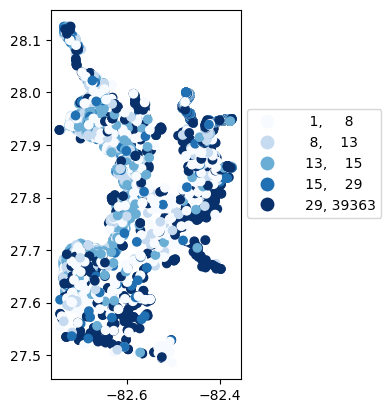

In [42]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [43]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize_generic?

##### secchi disk depth

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    83345.000000
mean         1.469260
std          0.899706
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 195
Usable results with inferred units: 0
Results outside threshold (0.0 to 6.867499256939848): 45


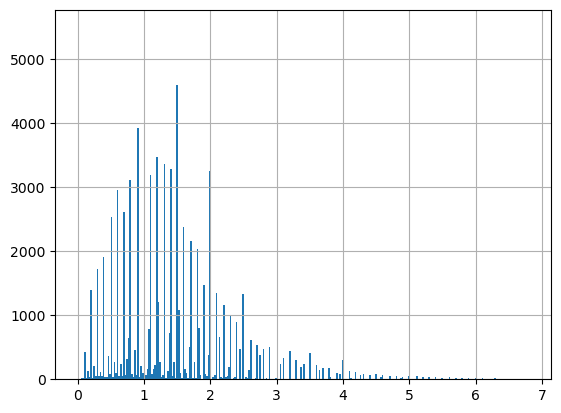

In [44]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [45]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

MonitoringLocationIdentifier ResultMeasureValue  \
78                  21FLHILL_WQX-171               0.60   
103                 21FLHILL_WQX-092               5.00   
118                 21FLHILL_WQX-161               0.50   
130               21FLHILL_WQX-14434               1.30   
132            21FLCOSP_WQX-COSPE6-4                2.6   
...                              ...                ...   
1420554                    21FLBSG-4                1.0   
1420555                    21FLBSG-4                1.1   
1420556                    21FLBSG-4                1.5   
1420557                    21FLBSG-4                1.4   
1420558                    21FLBSG-4                1.4   

        ResultMeasure/MeasureUnitCode QA_flag Units     Secchi  
78                                  m     NaN     m  0.6 meter  
103                                 m     NaN     m  5.0 meter  
118                                 m     NaN     m  0.5 meter  
130                                 m     NaN     m  1.3 meter  
132                                 m     NaN     m  2.6 meter  
...                               ...     ...   ...        ...  
1420554                             m     NaN     m  1.0 meter  
1420555                             m     NaN     m  1.1 meter  
1420556                             m     NaN     m  1.5 meter  
1420557                             m     NaN     m  1.4 meter  
1420558                             m     NaN     m  1.4 meter  

[83540 rows x 6 columns]

In [46]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

MonitoringLocationIdentifier ResultMeasureValue  \
734760                 21FLPDEM_WQX-14-02       Not Reported   
738001   21FLKWAT_WQX-PIN-COFFEEPOBAYOU-5       Not Reported   
741119   21FLKWAT_WQX-PIN-COFFEEPOBAYOU-1       Not Reported   
741919   21FLKWAT_WQX-PIN-COFFEEPOBAYOU-7       Not Reported   
746322            21FLPDEM_WQX-E2-D-19-02       Not Reported   
...                                   ...                ...   
1406650              USGS-273631082452600                NaN   
1406978              USGS-275100082280500                NaN   
1406983              USGS-275100082280500                NaN   
1407186              USGS-275530082383300                NaN   
1407426              USGS-275530082383300                NaN   

        ResultMeasure/MeasureUnitCode  \
734760                              m   
738001                            NaN   
741119                            NaN   
741919                            NaN   
746322                              m   
...                               ...   
1406650                           NaN   
1406978                           NaN   
1406983                           NaN   
1407186                           NaN   
1407426                           NaN   

                                                   QA_flag Units Secchi  
734760   ResultMeasureValue: "Not Reported" result cann...     m    NaN  
738001   ResultMeasureValue: "Not Reported" result cann...     m    NaN  
741119   ResultMeasureValue: "Not Reported" result cann...     m    NaN  
741919   ResultMeasureValue: "Not Reported" result cann...     m    NaN  
746322   ResultMeasureValue: "Not Reported" result cann...     m    NaN  
...                                                    ...   ...    ...  
1406650  ResultMeasureValue: missing (NaN) result; Resu...     m    NaN  
1406978  ResultMeasureValue: missing (NaN) result; Resu...     m    NaN  
1406983  ResultMeasureValue: missing (NaN) result; Resu...     m    NaN  
1407186  ResultMeasureValue: missing (NaN) result; Resu...     m    NaN  
1407426  ResultMeasureValue: missing (NaN) result; Resu...     m    NaN  

[195 rows x 6 columns]

In [47]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [48]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

MonitoringLocationIdentifier ResultMeasureValue  \
244364               NARS_WQX-NCCA10-1674                 -9   
734760                 21FLPDEM_WQX-14-02       Not Reported   
738001   21FLKWAT_WQX-PIN-COFFEEPOBAYOU-5       Not Reported   
741119   21FLKWAT_WQX-PIN-COFFEEPOBAYOU-1       Not Reported   
741919   21FLKWAT_WQX-PIN-COFFEEPOBAYOU-7       Not Reported   
...                                   ...                ...   
1406650              USGS-273631082452600                NaN   
1406978              USGS-275100082280500                NaN   
1406983              USGS-275100082280500                NaN   
1407186              USGS-275530082383300                NaN   
1407426              USGS-275530082383300                NaN   

        ResultMeasure/MeasureUnitCode  \
244364                           None   
734760                              m   
738001                            NaN   
741119                            NaN   
741919                            NaN   
...                               ...   
1406650                           NaN   
1406978                           NaN   
1406983                           NaN   
1407186                           NaN   
1407426                           NaN   

                                                   QA_flag Units      Secchi  
244364   ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...     m  -9.0 meter  
734760   ResultMeasureValue: "Not Reported" result cann...     m         NaN  
738001   ResultMeasureValue: "Not Reported" result cann...     m         NaN  
741119   ResultMeasureValue: "Not Reported" result cann...     m         NaN  
741919   ResultMeasureValue: "Not Reported" result cann...     m         NaN  
...                                                    ...   ...         ...  
1406650  ResultMeasureValue: missing (NaN) result; Resu...     m         NaN  
1406978  ResultMeasureValue: missing (NaN) result; Resu...     m         NaN  
1406983  ResultMeasureValue: missing (NaN) result; Resu...     m         NaN  
1407186  ResultMeasureValue: missing (NaN) result; Resu...     m         NaN  
1407426  ResultMeasureValue: missing (NaN) result; Resu...     m         NaN  

[196 rows x 6 columns]

All these were missing both a value and unit so nothing could be done

In [49]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

MonitoringLocationIdentifier  cnt      mean
0                   21FLBRA-1530-A    2  0.375000
1                  21FLBRA-1541B-A    3  1.166667
2                   21FLBRA-1574-A    1  0.250000
3                  21FLBRA-1574A-A    2  0.250000
4                  21FLBRA-1574A-B    1  1.250000
...                            ...  ...       ...
11222         USGS-280630082350900    3  1.966667
11223         USGS-280635082322100    2  2.100000
11224         USGS-280640082434700    3  2.302933
11225         USGS-280719082291400    2  1.000000
11226         USGS-280730082431800    3  1.947333

[11227 rows x 3 columns]

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  warnings.warn(


<Axes: >

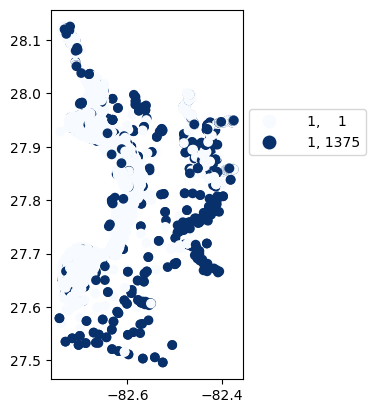

In [50]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<Axes: >

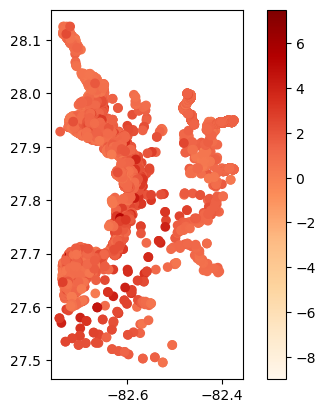

In [51]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    292117.000000
mean         25.299194
std          80.972324
min           0.000000
25%          21.200000
50%          25.900000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 112
Usable results with inferred units: 0
Results outside threshold (0.0 to 511.13314048135953): 1


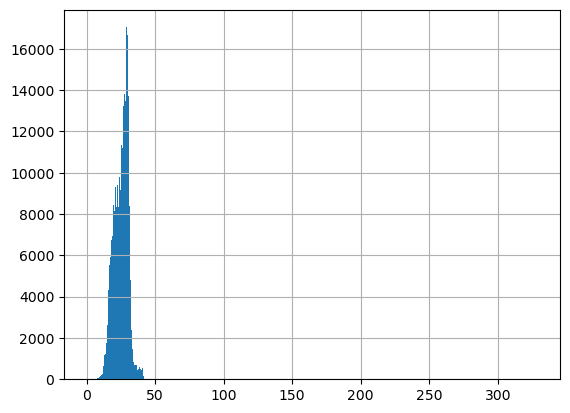

In [52]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [53]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

MonitoringLocationIdentifier ResultMeasureValue  \
2                   21FLHILL_WQX-047              28.19   
23                 21FLHILL_WQX-1509              27.67   
25                  21FLHILL_WQX-060              30.24   
27                   21FLTBW_WQX-NAB              30.67   
28                  21FLTBW_WQX-DISM               26.5   
...                              ...                ...   
1420858         USGS-273217082335701               28.9   
1420861         USGS-274322082245501               24.4   
1420866         USGS-274302082280801               25.0   
1420869         USGS-273926082304501               25.7   
1420872         USGS-274455082253601               26.1   

        ResultMeasure/MeasureUnitCode QA_flag           Temperature Units  
2                               deg C     NaN  28.19 degree_Celsius  degC  
23                              deg C     NaN  27.67 degree_Celsius  degC  
25                              deg C     NaN  30.24 degree_Celsius  degC  
27                              deg C     NaN  30.67 degree_Celsius  degC  
28                              deg C     NaN   26.5 degree_Celsius  degC  
...                               ...     ...                   ...   ...  
1420858                         deg C     NaN   28.9 degree_Celsius  degC  
1420861                         deg C     NaN   24.4 degree_Celsius  degC  
1420866                         deg C     NaN   25.0 degree_Celsius  degC  
1420869                         deg C     NaN   25.7 degree_Celsius  degC  
1420872                         deg C     NaN   26.1 degree_Celsius  degC  

[292229 rows x 6 columns]

In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [54]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

MonitoringLocationIdentifier ResultMeasureValue  \
739061            21FLPDEM_WQX-19-13       Not Reported   
739928            21FLPDEM_WQX-24-07       Not Reported   
741283            21FLPDEM_WQX-12-04       Not Reported   
746362            21FLPDEM_WQX-23-08       Not Reported   
752353            21FLPDEM_WQX-04-04       Not Reported   
...                              ...                ...   
1112113           21FLPDEM_WQX-35-01       Not Reported   
1116148           21FLPDEM_WQX-23-08       Not Reported   
1304127         USGS-280228082343000                NaN   
1402872                USGS-02306028                NaN   
1403155                USGS-02306028                NaN   

        ResultMeasure/MeasureUnitCode  \
739061                            NaN   
739928                            NaN   
741283                            NaN   
746362                            NaN   
752353                            NaN   
...                               ...   
1112113                           NaN   
1116148                           NaN   
1304127                           NaN   
1402872                           NaN   
1403155                           NaN   

                                                   QA_flag Temperature Units  
739061   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
739928   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
741283   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
746362   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
752353   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
...                                                    ...         ...   ...  
1112113  ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
1116148  ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
1304127  ResultMeasureValue: missing (NaN) result; Resu...         NaN  degC  
1402872  ResultMeasureValue: missing (NaN) result; Resu...         NaN  degC  
1403155  ResultMeasureValue: missing (NaN) result; Resu...         NaN  degC  

[86 rows x 6 columns]

We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [55]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [56]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

MonitoringLocationIdentifier ResultMeasureValue  \
739061            21FLPDEM_WQX-19-13       Not Reported   
739928            21FLPDEM_WQX-24-07       Not Reported   
741283            21FLPDEM_WQX-12-04       Not Reported   
746362            21FLPDEM_WQX-23-08       Not Reported   
752353            21FLPDEM_WQX-04-04       Not Reported   
...                              ...                ...   
1366141           21FLPDEM_WQX-24-01       Not Reported   
1366616           21FLPDEM_WQX-29-11       Not Reported   
1367168           21FLPDEM_WQX-12-02       Not Reported   
1402872                USGS-02306028                NaN   
1403155                USGS-02306028                NaN   

        ResultMeasure/MeasureUnitCode  \
739061                            NaN   
739928                            NaN   
741283                            NaN   
746362                            NaN   
752353                            NaN   
...                               ...   
1366141                         deg C   
1366616                         deg C   
1367168                         deg C   
1402872                           NaN   
1403155                           NaN   

                                                   QA_flag Temperature Units  
739061   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
739928   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
741283   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
746362   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
752353   ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
...                                                    ...         ...   ...  
1366141  ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
1366616  ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
1367168  ResultMeasureValue: "Not Reported" result cann...         NaN  degC  
1402872  ResultMeasureValue: missing (NaN) result; Resu...         NaN  degC  
1403155  ResultMeasureValue: missing (NaN) result; Resu...         NaN  degC  

[112 rows x 6 columns]

In [57]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

MonitoringLocationIdentifier  cnt       mean
0                   21FLBRA-1530-A   12  27.593333
1                   21FLBRA-1530-B    7  26.290000
2                  21FLBRA-1541A-A    6  26.016667
3                  21FLBRA-1541B-A    6  26.743333
4                   21FLBRA-1574-A    5  27.890000
...                            ...  ...        ...
14347         USGS-280726082313300    4  28.025000
14348         USGS-280728082301101   54  25.083333
14349         USGS-280729082313501    1  27.400000
14350         USGS-280730082313201    1  24.700000
14351         USGS-280730082431800   11  22.018182

[14352 rows x 3 columns]

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

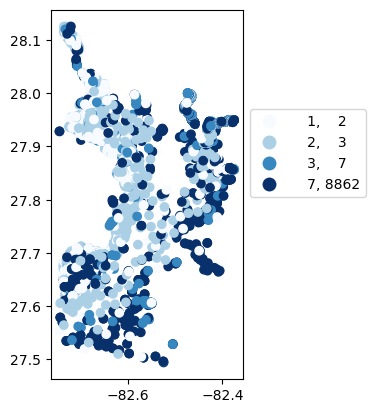

In [58]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<Axes: >

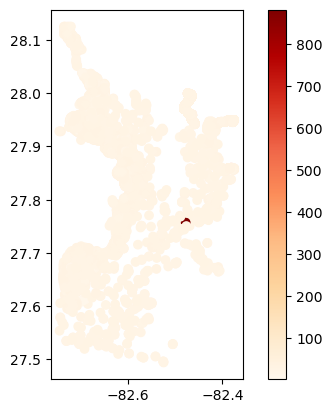

In [59]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [60]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [61]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

MonitoringLocationIdentifier ResultMeasureValue  \
0                   21FLHILL_WQX-585               9.32   
9                  21FLHILL_WQX-1611               4.90   
11                 21FLHILL_WQX-1606               2.56   
14                21FLPDEM_WQX-24-01               68.7   
19                  21FLTBW_WQX-DISN               6.36   
...                              ...                ...   
1420574                    21FLBSG-4                4.0   
1420575                    21FLBSG-4                7.2   
1420576                    21FLBSG-4                7.4   
1420577                    21FLBSG-4                7.9   
1420578                    21FLBSG-4                8.9   

        ResultMeasure/MeasureUnitCode QA_flag  \
0                                mg/L     NaN   
9                                mg/L     NaN   
11                               mg/L     NaN   
14                                  %     NaN   
19                               mg/L     NaN   
...                               ...     ...   
1420574                          mg/l     NaN   
1420575                          mg/l     NaN   
1420576                          mg/l     NaN   
1420577                          mg/l     NaN   
1420578                          mg/l     NaN   

                                       DO  
0                  9.32 milligram / liter  
9                   4.9 milligram / liter  
11                 2.56 milligram / liter  
14       5.676222371166 milligram / liter  
19                 6.36 milligram / liter  
...                                   ...  
1420574             4.0 milligram / liter  
1420575             7.2 milligram / liter  
1420576             7.4 milligram / liter  
1420577             7.9 milligram / liter  
1420578             8.9 milligram / liter  

[261663 rows x 5 columns]

In [62]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

MonitoringLocationIdentifier ResultMeasureValue  \
0                   21FLHILL_WQX-585               9.32   
9                  21FLHILL_WQX-1611               4.90   
11                 21FLHILL_WQX-1606               2.56   
14                21FLPDEM_WQX-24-01               68.7   
19                  21FLTBW_WQX-DISN               6.36   
...                              ...                ...   
1389924              21FLHILL_WQX-81               5.46   
1389932              21FLHILL_WQX-25                7.1   
1389933              21FLHILL_WQX-36               7.66   
1389940              21FLHILL_WQX-40               6.55   
1389941              21FLHILL_WQX-13               5.85   

        ResultMeasure/MeasureUnitCode QA_flag  \
0                                mg/L     NaN   
9                                mg/L     NaN   
11                               mg/L     NaN   
14                                  %     NaN   
19                               mg/L     NaN   
...                               ...     ...   
1389924                          mg/L     NaN   
1389932                          mg/L     NaN   
1389933                          mg/L     NaN   
1389940                          mg/L     NaN   
1389941                          mg/L     NaN   

                                       DO  
0                  9.32 milligram / liter  
9                   4.9 milligram / liter  
11                 2.56 milligram / liter  
14       5.676222371166 milligram / liter  
19                 6.36 milligram / liter  
...                                   ...  
1389924            5.46 milligram / liter  
1389932             7.1 milligram / liter  
1389933            7.66 milligram / liter  
1389940            6.55 milligram / liter  
1389941            5.85 milligram / liter  

[164674 rows x 5 columns]

Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [63]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

MonitoringLocationIdentifier  cnt      mean
0                   21FLBRA-1530-A   12  2.785000
1                   21FLBRA-1530-B    7  4.042857
2                  21FLBRA-1541A-A    6  4.721667
3                  21FLBRA-1541B-A    6  6.600000
4                   21FLBRA-1574-A    5  4.378000
...                            ...  ...       ...
12923         NARS_WQX-NCCA10-1672    8  5.437500
12924         NARS_WQX-NCCA10-1673   20  4.115000
12925         NARS_WQX-NCCA10-1674    6  2.466667
12926       NARS_WQX-NLA06608-0161    5  6.500000
12927        NARS_WQX-NLA_FL-10127    3  9.033333

[12928 rows x 3 columns]

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

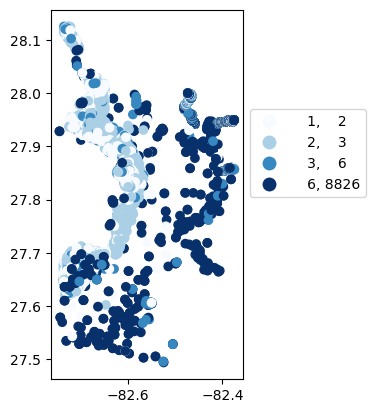

In [64]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<Axes: >

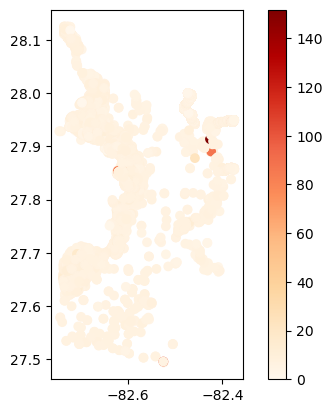

In [65]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    268444.000000
mean          7.764112
std           0.471263
min           0.370000
25%           7.530000
50%           7.890000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 129
Usable results with inferred units: 0
Results outside threshold (0.0 to 10.591692727696339): 7


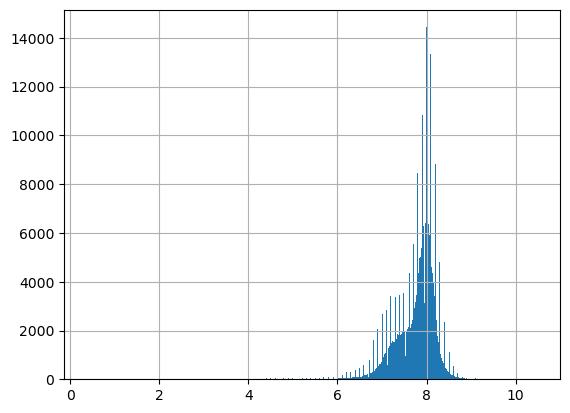

In [66]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [67]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
4                     7.48                          None     NaN   
5                     8.18                          None     NaN   
7                     7.81                          None     NaN   
12                    7.92                          None     NaN   
13                     7.8                          None     NaN   
...                    ...                           ...     ...   
1420867                7.9                     std units     NaN   
1420868                7.3                     std units     NaN   
1420870                7.8                     std units     NaN   
1420871                7.7                     std units     NaN   
1420873                7.6                     std units     NaN   

                         pH  
4        7.48 dimensionless  
5        8.18 dimensionless  
7        7.81 dimensionless  
12       7.92 dimensionless  
13        7.8 dimensionless  
...                     ...  
1420867   7.9 dimensionless  
1420868   7.3 dimensionless  
1420870   7.8 dimensionless  
1420871   7.7 dimensionless  
1420873   7.6 dimensionless  

[268573 rows x 4 columns]

'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    259646.000000
mean         21.831899
std          96.698848
min          -0.020000
25%          18.320000
50%          24.900000
75%          28.700000
max       48930.000000
dtype: float64
Unusable results: 1211
Usable results with inferred units: 0
Results outside threshold (0.0 to 602.0249895588677): 4


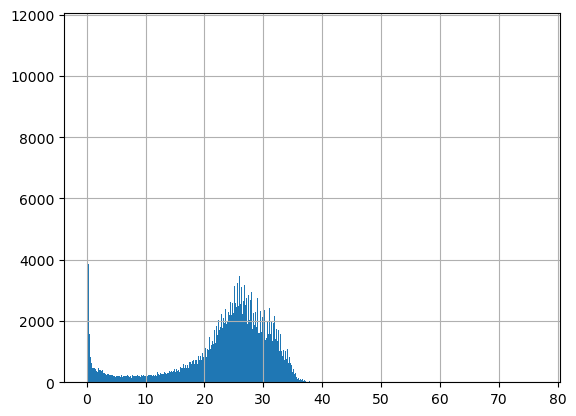

In [68]:
# Salinity
# Note: this has some weird units ('deg C') that may cause issue unless ignored
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
1                       40                          ppth     NaN   
6                       29                           PSS     NaN   
8                    26.04                           PSS     NaN   
15                    0.18                          ppth     NaN   
17                     5.9                          ppth     NaN   
...                    ...                           ...     ...   
1420560               21.3                           PSS     NaN   
1420562              20.97                           PSS     NaN   
1420565               19.9                           PSS     NaN   
1420571               20.4                           PSS     NaN   
1420572               21.8                           PSS     NaN   

                               Salinity  
1         40.0 Practical_Salinity_Units  
6         29.0 Practical_Salinity_Units  
8        26.04 Practical_Salinity_Units  
15        0.18 Practical_Salinity_Units  
17         5.9 Practical_Salinity_Units  
...                                 ...  
1420560   21.3 Practical_Salinity_Units  
1420562  20.97 Practical_Salinity_Units  
1420565   19.9 Practical_Salinity_Units  
1420571   20.4 Practical_Salinity_Units  
1420572   21.8 Practical_Salinity_Units  

[260857 rows x 4 columns]

##### Nitrogen

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


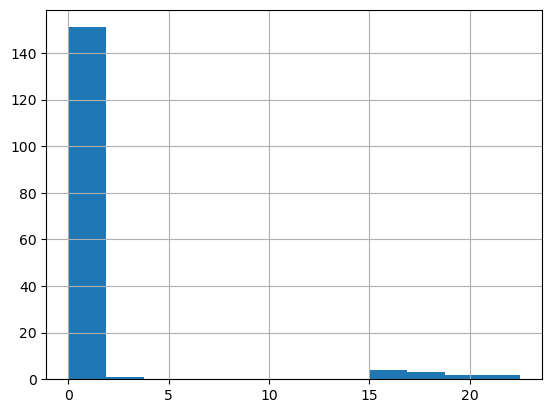

In [70]:
# Note Nitrogen value as '%' is in there for Cape, but weird
# Nitrogen had a problem with one of the units that is unexepected
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
221819                0.39                          mg/L     NaN   
237914              0.4475                          mg/L     NaN   
240683               0.425                          mg/L     NaN   
254260              0.4625                          mg/L     NaN   
255865             0.33625                          mg/L     NaN   
...                    ...                           ...     ...   
1418191              0.084                          mg/l     NaN   
1418199              0.166                          mg/l     NaN   
1418209              0.091                          mg/l     NaN   
1418243              0.057                          mg/l     NaN   
1418398               0.03                          mg/l     NaN   

                          Nitrogen  
221819      0.39 milligram / liter  
237914    0.4475 milligram / liter  
240683     0.425 milligram / liter  
254260    0.4625 milligram / liter  
255865   0.33625 milligram / liter  
...                            ...  
1418191    0.084 milligram / liter  
1418199    0.166 milligram / liter  
1418209    0.091 milligram / liter  
1418243    0.057 milligram / liter  
1418398     0.03 milligram / liter  

[165 rows x 4 columns]

##### Conductivity

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     10.000000
mean     703.700000
std       79.037333
min      606.000000
25%      627.750000
50%      731.500000
75%      775.750000
max      776.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 1177.9239977057255): 0


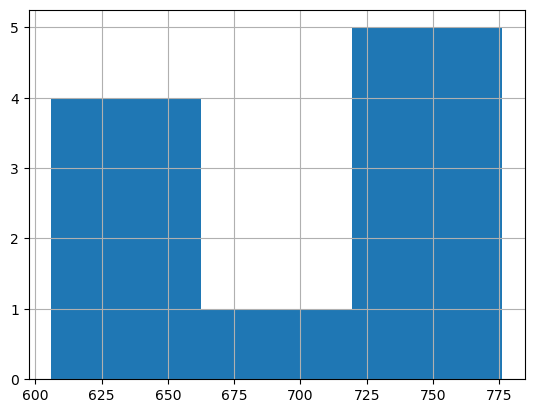

In [72]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True, errors='ignore')

In [73]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode  \
435911                NaN                         uS/cm   
441027                NaN                         uS/cm   
442075                NaN                         uS/cm   
444602                NaN                         uS/cm   
445071                NaN                         uS/cm   
447402                NaN                         uS/cm   
452213                NaN                         uS/cm   
468246                NaN                         uS/cm   
479305                626                         uS/cm   
483925                688                         uS/cm   
501477                606                         uS/cm   
502338                606                         uS/cm   
505452                633                         uS/cm   
574674                775                         uS/cm   
577422                776                         uS/cm   
578392                776                         uS/cm   
580503                776                         uS/cm   
585778                775                         uS/cm   

                                         QA_flag  \
435911  ResultMeasureValue: missing (NaN) result   
441027  ResultMeasureValue: missing (NaN) result   
442075  ResultMeasureValue: missing (NaN) result   
444602  ResultMeasureValue: missing (NaN) result   
445071  ResultMeasureValue: missing (NaN) result   
447402  ResultMeasureValue: missing (NaN) result   
452213  ResultMeasureValue: missing (NaN) result   
468246  ResultMeasureValue: missing (NaN) result   
479305                                       NaN   
483925                                       NaN   
501477                                       NaN   
502338                                       NaN   
505452                                       NaN   
574674                                       NaN   
577422                                       NaN   
578392                                       NaN   
580503                                       NaN   
585778                                       NaN   

                           Conductivity  
435911                              NaN  
441027                              NaN  
442075                              NaN  
444602                              NaN  
445071                              NaN  
447402                              NaN  
452213                              NaN  
468246                              NaN  
479305  626.0 microsiemens / centimeter  
483925  688.0 microsiemens / centimeter  
501477  606.0 microsiemens / centimeter  
502338  606.0 microsiemens / centimeter  
505452  633.0 microsiemens / centimeter  
574674  775.0 microsiemens / centimeter  
577422  776.0 microsiemens / centimeter  
578392  776.0 microsiemens / centimeter  
580503  776.0 microsiemens / centimeter  
585778  775.0 microsiemens / centimeter

##### Chlorophyll a

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    43333.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008720
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.15081314171981786): 197


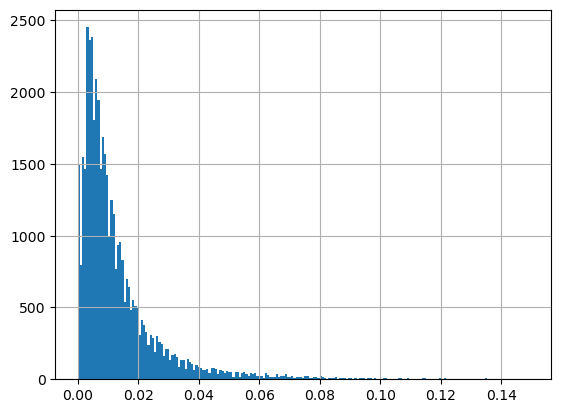

In [74]:
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [75]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
220691                5.94                          ug/L     NaN   
225845                1.45                          ug/L     NaN   
226740                2.77                          ug/L     NaN   
228078                3.87                          ug/L     NaN   
235708                8.15                          ug/L     NaN   
...                    ...                           ...     ...   
1420543              26.48                          ug/l     NaN   
1420553               1.83                          ug/l     NaN   
1420564              23.55                          ug/l     NaN   
1420566              37.07                          ug/l     NaN   
1420567              61.95                          ug/l     NaN   

                                    Chlorophyll  
220691   0.005940000000000001 milligram / liter  
225845                0.00145 milligram / liter  
226740                0.00277 milligram / liter  
228078                0.00387 milligram / liter  
235708   0.008150000000000001 milligram / liter  
...                                         ...  
1420543               0.02648 milligram / liter  
1420553               0.00183 milligram / liter  
1420564               0.02355 milligram / liter  
1420566               0.03707 milligram / liter  
1420567  0.061950000000000005 milligram / liter  

[44448 rows x 4 columns]

##### Organic Carbon

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    2.044800e+04
mean     2.597756e+04
std      1.956790e+06
min      0.000000e+00
25%      4.500000e+00
50%      7.100000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1913
Usable results with inferred units: 0
Results outside threshold (0.0 to 11766717.1262996): 8


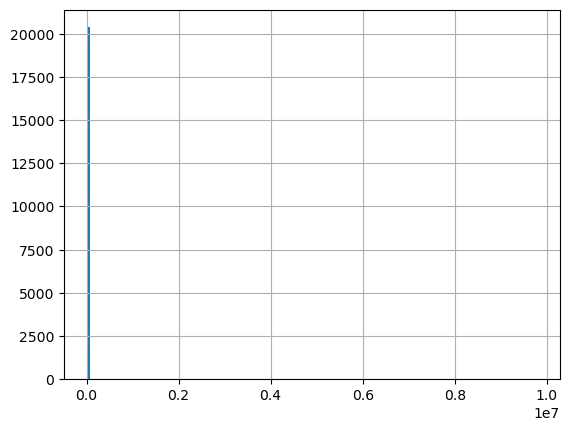

In [76]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [77]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
3                      3.8                          mg/L     NaN   
68                    28.0                          mg/L     NaN   
272                    3.4                          mg/L     NaN   
287                    6.7                          mg/L     NaN   
346                    5.8                          mg/L     NaN   
...                    ...                           ...     ...   
1417351               0.83                          mg/l     NaN   
1417401               0.71                          mg/l     NaN   
1417408               1.43                          mg/l     NaN   
1417416                0.9                          mg/l     NaN   
1417425               0.68                          mg/l     NaN   

                         Carbon  
3         3.8 milligram / liter  
68       28.0 milligram / liter  
272       3.4 milligram / liter  
287       6.7 milligram / liter  
346       5.8 milligram / liter  
...                         ...  
1417351  0.83 milligram / liter  
1417401  0.71 milligram / liter  
1417408  1.43 milligram / liter  
1417416   0.9 milligram / liter  
1417425  0.68 milligram / liter  

[22361 rows x 4 columns]

##### Turbidity (NTU)

In [78]:
# Bad units include 'm' and 'count'
#df_turb = df[df['CharacteristicName']=='Turbidity']

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     89954.000000
mean         16.424991
std         883.385635
min          -0.047700
25%           1.500000
50%           2.400000
75%           4.030000
max      200000.000000
dtype: float64
Unusable results: 1051
Usable results with inferred units: 0
Results outside threshold (0.0 to 5316.738802709647): 155


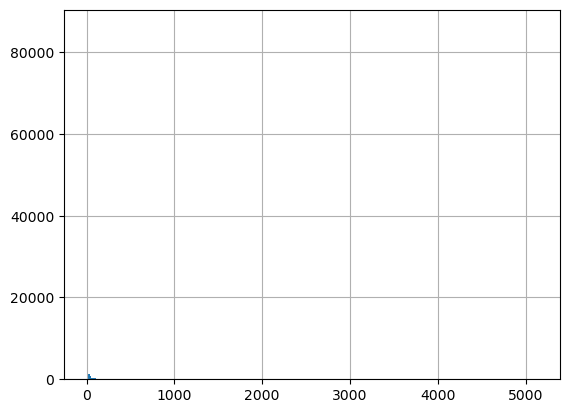

In [79]:
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [80]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
120                    2.3                           NTU     NaN   
143                    2.6                           NTU     NaN   
284                    0.9                           NTU     NaN   
296                    3.0                           NTU     NaN   
313                    2.0                           NTU     NaN   
...                    ...                           ...     ...   
1417417                2.0                          NTRU     NaN   
1417426                0.1                          NTRU     NaN   
1417470                0.1                          NTRU     NaN   
1417478                0.7                          NTRU     NaN   
1417688                0.9                          NTRU     NaN   

                                 Turbidity  
120      2.3 Nephelometric_Turbidity_Units  
143      2.6 Nephelometric_Turbidity_Units  
284      0.9 Nephelometric_Turbidity_Units  
296      3.0 Nephelometric_Turbidity_Units  
313      2.0 Nephelometric_Turbidity_Units  
...                                    ...  
1417417  2.0 Nephelometric_Turbidity_Units  
1417426  0.1 Nephelometric_Turbidity_Units  
1417470  0.1 Nephelometric_Turbidity_Units  
1417478  0.7 Nephelometric_Turbidity_Units  
1417688  0.9 Nephelometric_Turbidity_Units  

[91005 rows x 4 columns]

##### Sediment

In [81]:
df = harmonize.harmonize_generic(df, 'Sediment', report=False, errors='ignore')

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [82]:
df.loc[df['CharacteristicName']=='Sediment', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']]

ResultMeasureValue ResultMeasure/MeasureUnitCode  \
1385259                 28                             %   
1385260                 38                             %   
1406309               97.0                             %   
1406310               99.0                             %   
1406311              100.0                             %   
1406312              100.0                             %   
1406313              100.0                             %   
1406314              100.0                             %   
1417175                NaN                           NaN   

                                                   QA_flag  \
1385259                                                NaN   
1385260                                                NaN   
1406309                                                NaN   
1406310                                                NaN   
1406311                                                NaN   
1406312                                                NaN   
1406313                                                NaN   
1406314                                                NaN   
1417175  ResultMeasureValue: missing (NaN) result; Resu...   

                       Sediment  
1385259   280.0 gram / kilogram  
1385260   380.0 gram / kilogram  
1406309   970.0 gram / kilogram  
1406310   990.0 gram / kilogram  
1406311  1000.0 gram / kilogram  
1406312  1000.0 gram / kilogram  
1406313  1000.0 gram / kilogram  
1406314  1000.0 gram / kilogram  
1417175                     NaN

##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [83]:
df = harmonize.harmonize_generic(df, 'Phosphorus')

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [84]:
# len(df[df['CharacteristicName']=='Phosphorus'])
list(set(df['CharacteristicName']))

['Organic carbon',
 'Escherichia coli',
 'pH',
 'Phosphorus',
 'Temperature, water',
 'Nitrogen',
 'Conductivity',
 'Sediment',
 'Dissolved oxygen (DO)',
 'Turbidity',
 'Salinity',
 'Depth, Secchi disk depth',
 'Chlorophyll a',
 'Fecal Coliform']

In [85]:
# Total dissolved phosphorus
#df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

In [86]:
# Total phosphorus
#df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 54828
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988213): 8


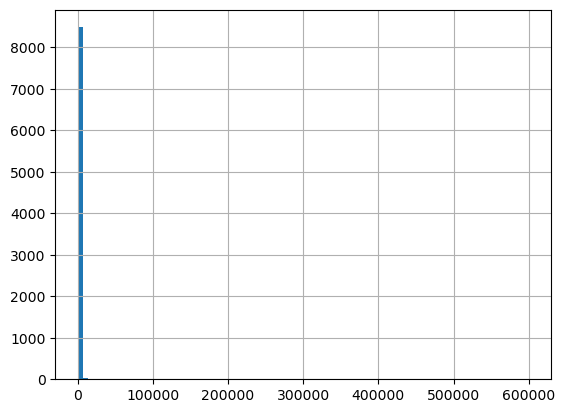

In [87]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True, errors='ignore')

In [88]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
10                     760                     cfu/100mL     NaN   
31                     300                       #/100mL     NaN   
41                     280                       #/100mL     NaN   
62                       5                     cfu/100mL     NaN   
65                     260                       #/100mL     NaN   
...                    ...                           ...     ...   
1415719                8.0                     MPN/100ml     NaN   
1415720                2.0                     MPN/100ml     NaN   
1415721                8.0                     MPN/100ml     NaN   
1415729               49.0                     MPN/100ml     NaN   
1420581                2.0                     cfu/100ml     NaN   

                                 Fecal_Coliform  
10                                          NaN  
31                                          NaN  
41                                          NaN  
62                                          NaN  
65                                          NaN  
...                                         ...  
1415719   8.0 Colony_Forming_Units / milliliter  
1415720   2.0 Colony_Forming_Units / milliliter  
1415721   8.0 Colony_Forming_Units / milliliter  
1415729  49.0 Colony_Forming_Units / milliliter  
1420581   2.0 Colony_Forming_Units / milliliter  

[63475 rows x 4 columns]

###### Excherichia Coli

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 4875
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


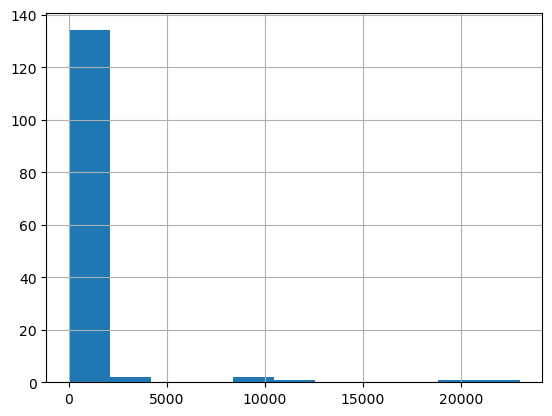

In [89]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True, errors='ignore')

In [90]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

ResultMeasureValue ResultMeasure/MeasureUnitCode  \
276038                 210                     MPN/100mL   
277435                4800                     MPN/100mL   
277860                74.5                     MPN/100mL   
277997               553.9                     MPN/100mL   
278270                  87                     MPN/100mL   
...                    ...                           ...   
1413020               21.0                     cfu/100ml   
1413087               10.0                     cfu/100ml   
1413178                1.0                     cfu/100ml   
1413212                NaN                           NaN   
1413262               11.0                     cfu/100ml   

                                                   QA_flag  \
276038                                                 NaN   
277435                                                 NaN   
277860                                                 NaN   
277997                                                 NaN   
278270                                                 NaN   
...                                                    ...   
1413020                                                NaN   
1413087                                                NaN   
1413178                                                NaN   
1413212  ResultMeasureValue: missing (NaN) result; Resu...   
1413262                                                NaN   

                                         E_coli  
276038                                      NaN  
277435                                      NaN  
277860                                      NaN  
277997                                      NaN  
278270                                      NaN  
...                                         ...  
1413020  21.0 Colony_Forming_Units / milliliter  
1413087  10.0 Colony_Forming_Units / milliliter  
1413178   1.0 Colony_Forming_Units / milliliter  
1413212                                     NaN  
1413262  11.0 Colony_Forming_Units / milliliter  

[5017 rows x 4 columns]

#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

In [91]:
from harmonize_wq import convert

In [92]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 259646 
Mean: 21.83189878295841 PSU


In [93]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
# Coerce quantity values to str (wrapper doesn't recognize quantity as it should)
cond_series = cond_series.astype(str)
# Convert values to PSU
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)

In [94]:
df.loc[df['Salinity'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']]

ResultMeasureValue ResultMeasure/MeasureUnitCode QA_flag  \
1                       40                          ppth     NaN   
6                       29                           PSS     NaN   
8                    26.04                           PSS     NaN   
15                    0.18                          ppth     NaN   
17                     5.9                          ppth     NaN   
...                    ...                           ...     ...   
1420560               21.3                           PSS     NaN   
1420562              20.97                           PSS     NaN   
1420565               19.9                           PSS     NaN   
1420571               20.4                           PSS     NaN   
1420572               21.8                           PSS     NaN   

                               Salinity  
1         40.0 Practical_Salinity_Units  
6         29.0 Practical_Salinity_Units  
8        26.04 Practical_Salinity_Units  
15        0.18 Practical_Salinity_Units  
17         5.9 Practical_Salinity_Units  
...                                 ...  
1420560   21.3 Practical_Salinity_Units  
1420562  20.97 Practical_Salinity_Units  
1420565   19.9 Practical_Salinity_Units  
1420571   20.4 Practical_Salinity_Units  
1420572   21.8 Practical_Salinity_Units  

[259656 rows x 4 columns]

In [95]:
# Now note updated values
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 259656 
Mean: 21.831071191884728 PSU


In [96]:
# Better to do after transposing so it doesn't generate duplicates?
# Start with two field 'Salinity' and 'Conductivity' that have already been harmonized
# Move the data from the Conductivity field to the salinity field

#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(harmonize_WQP.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [97]:
# Threshholds and reports
#e.g. PSU 0-42

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [98]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

ActivityStartDate ActivityStartTime/Time  \
0              2013-06-12               11:01:00   
1              2013-11-19               14:01:00   
2              2013-07-02               11:01:00   
3              2013-07-16               11:01:00   
4              2013-12-16               12:01:00   
...                   ...                    ...   
1420869        1955-04-08                    NaN   
1420870        1955-04-08                    NaN   
1420871        1957-10-21               14:05:00   
1420872        1955-04-08                    NaN   
1420873        1955-04-08                    NaN   

        ActivityStartTime/TimeZoneCode  
0                                  EST  
1                                  EST  
2                                  EST  
3                                  EST  
4                                  EST  
...                                ...  
1420869                            NaN  
1420870                            NaN  
1420871                            EST  
1420872                            NaN  
1420873                            NaN  

[1420874 rows x 3 columns]

In [99]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 100662 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


ActivityStartDate         Activity_datetime
0              2013-06-12 2013-06-12 16:01:00+00:00
1              2013-11-19 2013-11-19 19:01:00+00:00
2              2013-07-02 2013-07-02 16:01:00+00:00
3              2013-07-16 2013-07-16 16:01:00+00:00
4              2013-12-16 2013-12-16 17:01:00+00:00
...                   ...                       ...
1420869        1955-04-08                       NaT
1420870        1955-04-08                       NaT
1420871        1957-10-21 1957-10-21 19:05:00+00:00
1420872        1955-04-08                       NaT
1420873        1955-04-08                       NaT

[1420874 rows x 2 columns]

Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

#### Depth

In [100]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


378256     2.00
379011     3.00
388657     2.00
398514     3.00
426818     0.10
           ... 
1106204    0.43
1110288    0.38
1112509    0.43
1113367    0.38
1113859    0.33
Name: ResultDepthHeightMeasure/MeasureValue, Length: 261, dtype: float64

Data are often lacking sample depth metadata, even this small number including depth is good

#### Characteristic to Column (long to wide format)

In [101]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

OrganizationIdentifier  \
0                 21FLHILL_WQX   
1                 21FLSEAS_WQX   
2                 21FLHILL_WQX   
3                 21FLHILL_WQX   
4                 21FLHILL_WQX   
...                        ...   
1420869                USGS-FL   
1420870                USGS-FL   
1420871                USGS-FL   
1420872                USGS-FL   
1420873                USGS-FL   

                                    OrganizationFormalName  \
0        Environmental Protection Commission of Hillsbo...   
1           Florida Department of Environmental Protection   
2        Environmental Protection Commission of Hillsbo...   
3        Environmental Protection Commission of Hillsbo...   
4        Environmental Protection Commission of Hillsbo...   
...                                                    ...   
1420869                  USGS Florida Water Science Center   
1420870                  USGS Florida Water Science Center   
1420871                  USGS Florida Water Science Center   
1420872                  USGS Florida Water Science Center   
1420873                  USGS Florida Water Science Center   

                ActivityIdentifier ActivityStartDate ActivityStartTime/Time  \
0         21FLHILL_WQX-130612585-W        2013-06-12               11:01:00   
1        21FLSEAS_WQX-481901119134        2013-11-19               14:01:00   
2         21FLHILL_WQX-130702047-M        2013-07-02               11:01:00   
3           21FLHILL_WQX-130716021        2013-07-16               11:01:00   
4         21FLHILL_WQX-131216112-M        2013-12-16               12:01:00   
...                            ...               ...                    ...   
1420869         nwisfl.01.95500762        1955-04-08                    NaN   
1420870         nwisfl.01.95500762        1955-04-08                    NaN   
1420871         nwisfl.01.95800924        1957-10-21               14:05:00   
1420872         nwisfl.01.95500782        1955-04-08                    NaN   
1420873         nwisfl.01.95500782        1955-04-08                    NaN   

        ActivityStartTime/TimeZoneCode MonitoringLocationIdentifier  \
0                                -0500             21FLHILL_WQX-585   
1                                -0500       21FLSEAS_WQX-48SEAS190   
2                                -0500             21FLHILL_WQX-047   
3                                -0500             21FLHILL_WQX-021   
4                                -0500             21FLHILL_WQX-112   
...                                ...                          ...   
1420869                            NaN         USGS-273926082304501   
1420870                            NaN         USGS-273926082304501   
1420871                          -0500                USGS-02306001   
1420872                            NaN         USGS-274455082253601   
1420873                            NaN         USGS-274455082253601   

         ResultIdentifier  DataLoggerLine ResultDetectionConditionText  ...  \
0        STORET-301235413             NaN                          NaN  ...   
1        STORET-310535134             NaN                          NaN  ...   
2        STORET-300620295             NaN                          NaN  ...   
3        STORET-300666279             NaN                          NaN  ...   
4        STORET-301229196             NaN                          NaN  ...   
...                   ...             ...                          ...  ...   
1420869      NWIS-6842312             NaN                          NaN  ...   
1420870      NWIS-6842315             NaN                          NaN  ...   
1420871      NWIS-6894181             NaN                          NaN  ...   
1420872      NWIS-6842712             NaN                          NaN  ...   
1420873      NWIS-6842715             NaN                          NaN  ...   

        QA_Temperature QA_Nitrogen QA_Conductivity QA_Sediment QA_DO  \
0                  NaN         

In [102]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [103]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

66383 fewer rows


In [104]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

Empty DataFrame
Columns: [ResultMeasureValue, ResultMeasure/MeasureUnitCode, Carbon, QA_Carbon]
Index: []

Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [105]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [106]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'Conductivity', 'Chlorophyll', 'Carbon', 'Turbidity',
       'Sediment', 'Phosphorus', 'TP_Phosphorus', 'TDP_Phosphorus',
       'Other_Phosphorus', 'Fecal_Coliform', 'E_coli', 'Activity_datetime',
       'Depth', 'QA_Carbon', 'QA_E_coli', 'QA_pH', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Temperature',
       'QA_Nitrogen', 'QA_Conductivity', 'QA_Sediment', 'QA_DO',
       'QA_Turbidity', 'QA_Salinity', 'QA_Secchi', 'QA_Chlorophyll',
       'QA_Fecal_Coliform'],
      dtype='object')

In [107]:
# look at main table results (first 5)
main_df.head()

OrganizationIdentifier                             OrganizationFormalName  \
0           21FLHILL_WQX  Environmental Protection Commission of Hillsbo...   
1           21FLSEAS_WQX     Florida Department of Environmental Protection   
2           21FLHILL_WQX  Environmental Protection Commission of Hillsbo...   
3           21FLHILL_WQX  Environmental Protection Commission of Hillsbo...   
4           21FLHILL_WQX  Environmental Protection Commission of Hillsbo...   

          ActivityIdentifier MonitoringLocationIdentifier ProviderName Secchi  \
0   21FLHILL_WQX-130612585-W             21FLHILL_WQX-585       STORET    NaN   
1  21FLSEAS_WQX-481901119134       21FLSEAS_WQX-48SEAS190       STORET    NaN   
2   21FLHILL_WQX-130702047-M             21FLHILL_WQX-047       STORET    NaN   
3     21FLHILL_WQX-130716021             21FLHILL_WQX-021       STORET    NaN   
4   21FLHILL_WQX-131216112-M             21FLHILL_WQX-112       STORET    NaN   

            Temperature                      DO                  pH  \
0                   NaN  9.32 milligram / liter                 NaN   
1                   NaN                     NaN                 NaN   
2  28.19 degree_Celsius                     NaN                 NaN   
3                   NaN                     NaN                 NaN   
4                   NaN                     NaN  7.48 dimensionless   

                        Salinity  ... QA_Temperature QA_Nitrogen  \
0                            NaN  ...            NaN         NaN   
1  40.0 Practical_Salinity_Units  ...            NaN         NaN   
2                            NaN  ...            NaN         NaN   
3                            NaN  ...            NaN         NaN   
4                            NaN  ...            NaN         NaN   

  QA_Conductivity QA_Sediment QA_DO QA_Turbidity QA_Salinity QA_Secchi  \
0             NaN         NaN   NaN          NaN         NaN       NaN   
1             NaN         NaN   NaN          NaN         NaN       NaN   
2             NaN         NaN   NaN          NaN         NaN       NaN   
3             NaN         NaN   NaN          NaN         NaN       NaN   
4             NaN         NaN   NaN          NaN         NaN       NaN   

  QA_Chlorophyll QA_Fecal_Coliform  
0            NaN               NaN  
1            NaN               NaN  
2            NaN               NaN  
3            NaN               NaN  
4            NaN               NaN  

[5 rows x 41 columns]

In [108]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['QA_Carbon',
 'QA_E_coli',
 'QA_pH',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Temperature',
 'QA_Nitrogen',
 'QA_Conductivity',
 'QA_Sediment',
 'QA_DO',
 'QA_Turbidity',
 'QA_Salinity']

<Axes: >

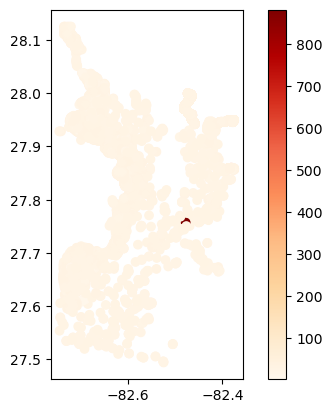

In [109]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)